In [1]:
import boost_histogram as bh
import numpy as np
import matplotlib.pyplot as plt

# Using boost-histogram

This workbook was designed with Boost-Histogram 0.5.2 (updated from 0.5.0) and Python 3 in mind.

## 1: Basic 1D histogram

Let's start with the basics. We will create a histogram using boost-histogram and fill it.

### 1.1: Data

Let's make a 1d dataset to run on.

In [2]:
data1 = np.random.normal(3.5, 2.5, size=1_000_000)

Now, let's make a histogram

In [3]:
hist1 = bh.histogram(bh.axis.regular(40, -2, 10))

In [4]:
hist1.fill(data1)

histogram(
  regular(40, -2, 10),
  storage=double
) # Sum: 981610 (1e+06 with flow)

You can see that the histogram has been filled. Let's explicitly check to see how many entries are in the histogram:

In [5]:
hist1.sum()

981610.0

What happened to the missing items? They are in the underflow and overflow bins:

In [6]:
hist1.sum(flow=True)

1000000.0

Like ROOT, we have overflow bins by default. We can turn them off, but they enable some powerful things like projections.

Let's plot this (Hist should make this easier):

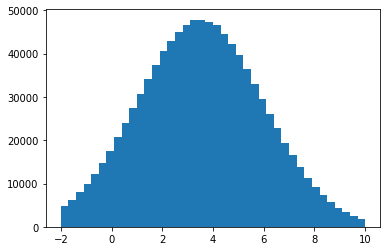

In [7]:
plt.bar(hist1.axes[0].centers, hist1.view(), width=hist1.axes[0].widths);

Note: You can leave off the `.view()` if you want to - histograms conform to the buffer protocol. Also, you can select the axes before or after calling `.centers`; this is very useful for ND histograms.

From now on, let's be lazy

In [8]:
plothist = lambda h: plt.bar(h.axes[0].centers, h, width=h.axes[0].widths);

Aside: here's step. It's quite ugly for us, just like it is for numpy. Or anyone.

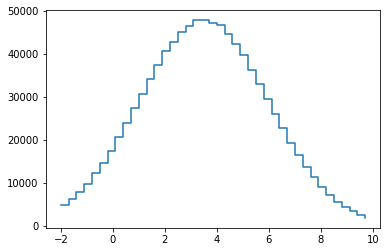

In [9]:
plt.step(hist1.axes[0].edges[:-1], hist1, where='post');

No plotting is built in, but the data is easy to access.

## 2: Drop-in replacement for Numpy

To start using this yourself, you don't even need to change your code. Let's try the numpy adapters.

In [10]:
bins2, edges2 = bh.numpy.histogram(data1, bins=10)

In [11]:
b2, e2 = np.histogram(data1, bins=10)

In [12]:
bins2 - b2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [13]:
e2 - edges2

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -8.88178420e-16,
       -1.77635684e-15, -1.77635684e-15,  0.00000000e+00,  1.77635684e-15,
       -3.55271368e-15, -3.55271368e-15,  0.00000000e+00])

Not bad! Let's start moving to the boost-histogram API, so we can use our little plotting function:

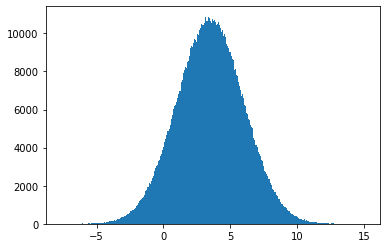

In [14]:
hist2 = bh.numpy.histogram(data1, bins='auto', bh=True)
plothist(hist2);

Now we can move over to boost-histogram one step at a time! Just to be complete, we can also go the other direction:

In [15]:
b2p, e2p = bh.numpy.histogram(data1, bins=10, bh=True).to_numpy()
b2p == b2

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

## 3: More dimensions

The same API works for multiple dimensions.

In [16]:
hist3 = bh.histogram(
    bh.axis.regular(150, -1.5, 1.5),
    bh.axis.regular(100, -1, 1)
)

In [17]:
def make_2D_data(*, mean=(0,0), widths=(1,1), size=1_000_000):
    cov = np.asarray(widths) * np.eye(2)
    return np.random.multivariate_normal(mean, cov, size=size).T

In [18]:
data3x = make_2D_data(mean=[-.75, .5], widths=[.2, 0.02])
data3y = make_2D_data(mean=[.75, .5], widths=[.2, 0.02])

From here on out, I will be using `.reset()` before a `.fill()`, just to make sure each cell in the notebook can be rerun.

In [19]:
hist3.reset()
hist3.fill(*data3x)
hist3.fill(*data3y)

histogram(
  regular(150, -1.5, 1.5),
  regular(100, -1, 1),
  storage=double
) # Sum: 1.90598e+06 (2e+06 with flow)

Again, let's make plotting a little function:

In [20]:
def plothist2d(h):
    X, Y = h.axes.edges
    X, Y = np.broadcast_arrays(X, Y)

    return plt.pcolormesh(X, Y, h)

> The above code is the same as doing:
> 
> ```python
X, Y = np.meshgrid(*(a.edges for a in h.axes, indexing='ij')
```

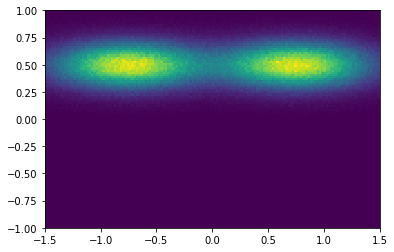

In [21]:
plothist2d(hist3);

Let's try a 3D histogram

In [22]:
data3d = [np.random.normal(size=1_000_000) for _ in range(3)]

hist3d = bh.histogram(
    bh.axis.regular(150, -5, 5),
    bh.axis.regular(100, -5, 5),
    bh.axis.regular(100, -5, 5)
)

hist3d.fill(*data3d)

histogram(
  regular(150, -5, 5),
  regular(100, -5, 5),
  regular(100, -5, 5),
  storage=double
) # Sum: 1e+06

Let's project to the first two axes:

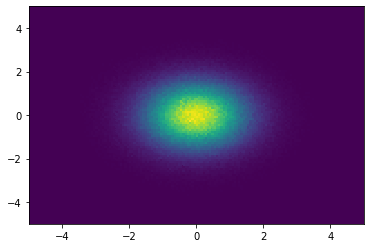

In [23]:
plothist2d(hist3d.project(0,1));

## 4: UHI

Let's explore the boost-histogram UHI syntax. We will reuse the previous 2D histogram from part 3:

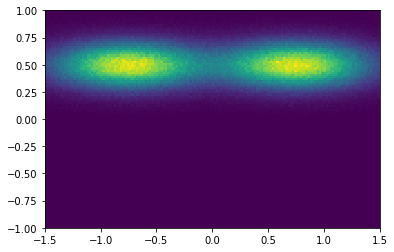

In [24]:
plothist2d(hist3);

I can see that I want y from 0.25 to 0.75, in data coordinates:

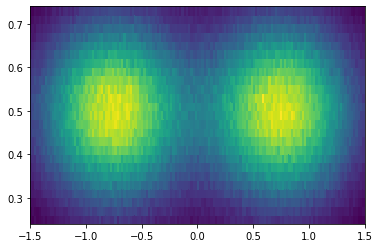

In [25]:
plothist2d(hist3[:, bh.loc(.25):bh.loc(.75)]);

What's the contents of a bin?

In [26]:
hist3[100,87]

199.0

How about in data coordinates?

In [27]:
hist3[bh.loc(.5), bh.loc(.75)]

199.0

> Note: to get the coordinates manually:
> 
> ```python
hist3.axes[0].index(.5) == 100
hist3.axes[1].index(.75) == 87
```

How about a 1d histogram?

WARNING: `bh.project` may change names in next release, possibly will just become `sum`.

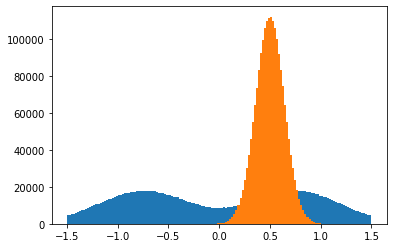

In [28]:
plothist(hist3[:, ::bh.project]);
plothist(hist3[::bh.project, :]);

Let's look at one part and rebin:

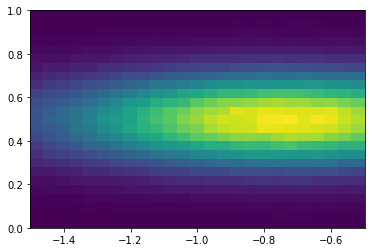

In [29]:
plothist2d(hist3[:50:bh.rebin(2), 50::bh.rebin(2)]);

What is the value at `(-.75, .5)`?

In [30]:
hist3[bh.loc(-.75), bh.loc(.5)]

1027.0

## 5: Understanding accumulators

Boost-histogram has several different storages; storages store accumulators. Let's try making a profile.

In [31]:
mean = bh.accumulators.mean()
mean.fill([.3, .4, .5])

mean(count=3, value=0.4, variance=0.01)

Here's a quick example accessing the values:

In [32]:
print(f"mean.count={mean.count} mean.value={mean.value} mean.variance={mean.variance}")

# Python 3.8:
# print(f"{mean.count=} {mean.value=} {mean.variance=}")

mean.count=3.0 mean.value=0.39999999999999997 mean.variance=0.010000000000000005


## 6: Changing the storage

In [33]:
hist6 = bh.histogram(bh.axis.regular(10,0,10), storage=bh.storage.mean)

In [34]:
hist6.fill([0.5]*3, sample=[.3, .4, .5])

histogram(
  regular(10, 0, 10),
  storage=mean
) # Sum: mean(count=3, value=0.4, variance=0.01) (mean(count=3, value=nan, variance=0.01) with flow)

In [35]:
hist6[0]

mean(count=3, value=0.4, variance=0.01)

> In the current beta, the values here are not accessable via `.view()` or with the buffer protocol.

## 7: Making a density histogram

Let's try to make a density histogram like Numpy's.

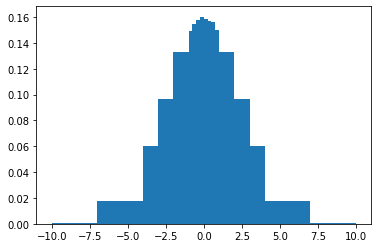

In [36]:
bins = [-10, -7, -4, -3, -2, -1, -.75, -.5, -.25, 0, .25, .5, .75, 1, 2, 3, 4, 7, 10]
d7, e7 = np.histogram(data1 - 3.5, bins=bins, density=True)
plt.hist(data1 - 3.5, bins=bins, density=True);

Yes, it's ugly. Don't judge.

Density is not supported yet! What do we do?

In [37]:
hist7 = bh.numpy.histogram(data1 - 3.5, bins=bins, bh=True)

widths = hist7.axes.widths
area = np.prod(widths, axis=0)

area

array([3.  , 3.  , 1.  , 1.  , 1.  , 0.25, 0.25, 0.25, 0.25, 0.25, 0.25,
       0.25, 0.25, 1.  , 1.  , 1.  , 3.  , 3.  ])

Yes, that does not need to be so complicated for 1D, but it's general.

In [38]:
factor = np.sum(hist7.view())
view = hist7.view() / (factor * area)

Setting with array support would make this simpler, and is planned.

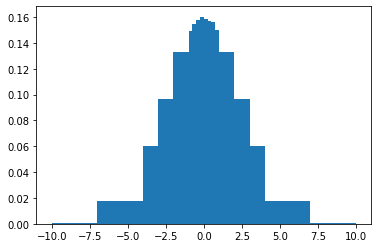

In [39]:
plt.bar(hist7.axes[0].centers, view, width=hist7.axes[0].widths);

# 8: Axis types

There are more axes types, and they all provide the same API in histograms, so they all just work without changes:

In [40]:
hist8 = bh.histogram(
    bh.axis.regular_log(30, 1,10),
    bh.axis.regular_sqrt(30, 1,10)
)

In [41]:
hist8.reset()
hist8.fill(*make_2D_data(mean=(5,5), widths=(5,5)))

histogram(
  regular_log(30, 1, 10),
  regular_sqrt(30, 1, 10),
  storage=double
) # Sum: 902906 (1e+06 with flow)

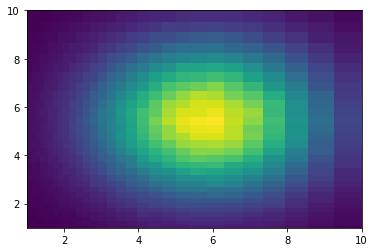

In [42]:
plothist2d(hist8);

# 9: And, circular, too!

In [43]:
hist9 = bh.histogram(bh.axis.circular(30, 0, 2*np.pi))
hist9.fill(np.random.uniform(0, np.pi*4, size=300))

histogram(
  circular(30, 0, 6.28319),
  storage=double
) # Sum: 300

Now, the really complicated part, making a circular histogram:


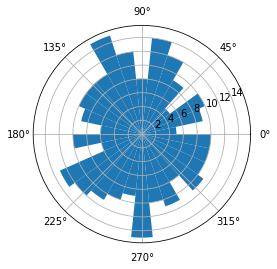

In [44]:
ax = plt.subplot(111, polar=True)
plothist(hist9);